# Q2

In [405]:
import librosa
import librosa.display
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

versions = ['HU33', 'SC06', 'FI66', 'FI80', 'midi']

chroma_type = ['stft', 'cq', 'cens']
# Naming mistake, cq should be cqt

template_type = ['binary', 'ks', 'harmonic']

# I'll just choose the easy way out...
key2num = {
    "A:maj": 0, "A#:maj": 1, "Bb:maj": 1, "B:maj": 2,
    "C:maj": 3, "C#:maj": 4, "Db:maj": 4, "D:maj": 5, "D#:maj": 6, "Eb:maj": 6, 
    "E:maj": 7, "F:maj": 8, "F#:maj": 9, "G:maj": 10, "G#:maj": 11, "Ab:maj": 11,
    "A:min": 12, "A#:min": 13, "Bb:min": 13, "B:min": 14,
    "C:min": 15, "C#:min": 16, "Db:min": 16, "D:min": 17, "D#:min": 18, "Eb:min": 18, 
    # There is D#:min and Eb:min, This could be a problem when finding key
    "E:min": 19, "F:min": 20, "F#:min": 21, "G:min": 22, "G#:min": 23, "Ab:min": 23,
    }

binary_templates = [[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1], [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]]

ks_templates = [[6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88], 
                [6.33, 2.68, 3.52, 5.38, 2.6, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]]

# Tested with an irrelevent vector, perform a differnt result than binary_templates
#ks_templates = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

alpha = 0.9

uc = [1 + alpha + alpha**3 + alpha**7,
        0,
        0,
        0,
        alpha**4,
        0,
        0,
        alpha**2+alpha**5,
        0,
        0,
        alpha**6,
        0]


u = [None]*12
for i in range(12):
    # 0 means ua, 1 means ua#, ...
    u[i] = np.roll(uc, i-3)

harmonic_major_template = [0] * 12
harmonic_minor_template = [0] * 12

for i in range(12):
    if binary_templates[0][i] == 1:
        harmonic_major_template += u[(i+3)%12]
    if binary_templates[1][i] == 1:
        harmonic_minor_template += u[(i+3)%12]    

harmonic_templates = [harmonic_major_template, harmonic_minor_template]


In [2]:
def get_SWD_keys(versions, key2num):
    """
    Get keys for each song in each genres in GTZAN dataset. The path of the set is fixed.
    
    :param: versions
    :return: A dict that contains the true key of each genres.
    
    Example:
        key0 = d[1]['HU33']
    """
    
    d = {}    
    # Load audio key
    key_path = "data/SWD/02_Annotations/ann_audio_globalkey.csv"
    with open(key_path, mode='r') as f:
        
        # Skip first line
        line = f.readline()
        
        while True:
            
            # Parse the string
            line = f.readline()
            if not line:
                break
                
            line = line.split('\"')
            index = int(line[1].split('-')[1])
            
            version = line[3]
            if not version in versions:
                continue
                
            if not version in d:
                d[version] = {}
            
            if not line[5] in key2num:
                print('Error')
            
            d[version][index] = key2num[line[5]]
        # While there are two audio key files, the second file does not seem to be necessary to load.
        
    # Load score key
    key_path = "data/SWD/02_Annotations/ann_score_globalkey.csv"
    with open(key_path, mode='r') as f:
        # Parse the string
        
        # Skip first line
        line = f.readline()
        
        while True:
            
            line = f.readline()
            if not line:
                break

            line = line.split('\"')
            index = int(line[1].split('-')[1])
            
            version = 'midi'
                
            if not version in d:
                d[version] = {}
                
            if not line[3] in key2num:
                print('Error')
            
            d[version][index] = key2num[line[3]]
        
    
    for v in versions:
        d[v] = list(d[v].values())
        d[v].insert(0, -1)
    
    return d
    
    

In [3]:
keys = get_SWD_keys(versions, key2num)

In [4]:
keys['FI66']

[-1,
 15,
 22,
 17,
 12,
 7,
 17,
 17,
 20,
 12,
 14,
 10,
 14,
 3,
 14,
 14,
 5,
 5,
 17,
 0,
 20,
 8,
 21,
 10,
 22]

In [5]:
def create_SWD_Chroma(versions):
    """
    Create chroma file from mp3 and mid, save them to result/SWD/
    
    :param: versions(list): The list of versions. 
    :return: None
    """
    
    version2fileType = {"FI66": ".mp3", "FI80": ".mp3", "HU33": ".wav", "SC06": ".wav", "midi": ".mid"}
    

    if(not os.path.isdir('result/SWD/chroma')):
        for v in versions:
            
            # Skip midi for now
            if v == "midi":
                continue
            
            for i in range(24):
                # 24 is the numbers songs of each genres'data 

                filename = "data/SWD/01_RawData/audio_wav/" + v + "/Schubert_D911-" + str(i+1).zfill(2) + "_" + v + version2fileType[v]
                y, sr = librosa.load(filename)

                # STFT chromagram
                chroma_stft = librosa.feature.chroma_stft(
                    y=y, sr=sr, n_chroma=12, n_fft=4096)
                
                # CQT chromagram
                chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
                
                # Chroma Energy Normalized chromagram
                chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
                
                # Create new files for three types of chroma
                
                filename = "result/SWD/chroma/" + v + "/stft/" + str(i+1).zfill(5) + ".chroma_stft.txt"
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:
                    np.savetxt(filename, chroma_stft)
                    
                filename = "result/SWD/chroma/" + v + "/cq/" + str(i+1).zfill(5) + ".chroma_cq.txt"
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:
                    np.savetxt(filename, chroma_cq)
                    
                filename = "result/SWD/chroma/" + v + "/cens/" + str(i+1).zfill(5) + ".chroma_cens.txt"
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:
                    np.savetxt(filename, chroma_cens)

    v = "midi"
    for i in range(24):

        filename = "data/SWD/01_RawData/score_midi/Schubert_D911-" + str(i+1).zfill(2) + version2fileType[v]
        midi_data = pretty_midi.PrettyMIDI(filename)

        chroma_midi = midi_data.get_chroma(fs=100) # Not sure how fs supposed to be

        filename = "result/SWD/chroma/" + v + "/"  + str(i+1).zfill(5) + "." + v + ".txt"
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, mode='w') as f:
            np.savetxt(filename, chroma_midi)
            
        
        
    return

In [6]:
create_SWD_Chroma(versions)

In [7]:
def get_SWD_Chroma(version:str, index:int, chroma_type:str=None):
    """
    Get chroma from txt
    
    :return: (ndarray)
    """
    
    if not version == "midi":
        filename = "result/SWD/chroma/" + version + "/" + chroma_type + "/" + str(index).zfill(5) + ".chroma_" + chroma_type + ".txt"
        with open(filename, mode='r') as f:
            return np.loadtxt(filename)
    else:
        filename = "result/SWD/chroma/" + version + "/"  + str(index).zfill(5) + "." + version + ".txt"
        with open(filename, mode='r') as f:
            return np.loadtxt(filename)

In [8]:
get_SWD_Chroma("FI66", 1, "cens")

array([[0.31588927, 0.31109607, 0.30639002, ..., 0.63326299, 0.63054359,
        0.62742054],
       [0.41401154, 0.4080548 , 0.40170783, ..., 0.08710974, 0.09396885,
        0.10104251],
       [0.42919198, 0.43215033, 0.43497959, ..., 0.22854227, 0.22922067,
        0.22984125],
       ...,
       [0.23344074, 0.23518088, 0.23710883, ..., 0.        , 0.        ,
        0.        ],
       [0.23285231, 0.23378283, 0.23464169, ..., 0.01722649, 0.01816434,
        0.01907932],
       [0.23285231, 0.23378283, 0.23464169, ..., 0.06988326, 0.0758045 ,
        0.08196318]])

In [9]:
get_SWD_Chroma("midi", 1)

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [ 65.,  65.,  65., ..., 126., 126., 126.],
       ...,
       [ 65.,  65.,  65., ...,  84.,  84.,  84.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [10]:
def create_SWD_tonic_pitch(versions:list, chroma_type:list):
    """
    Create tonic pitch list from chroma files if not already exsists.
    Start from A == 0
    
    """
    if(not os.path.isdir('result/SWD/tonic_pitch')):
        tonic_pitch_path = "result/SWD/tonic_pitch/"
        
        for v in versions:
            tonic_pitch_versions_path = tonic_pitch_path + v + "/"
            
            if v != "midi":
                for c in chroma_type:

                    filename = tonic_pitch_versions_path + c + ".txt"
                    os.makedirs(os.path.dirname(filename), exist_ok=True)
                    with open(filename, mode='w') as f:

                        for i in range(1, 25):
                        # 24 is the numbers of songs of each versions'data
                        # Data starts from 1
                            chroma = get_SWD_Chroma(v, i, c)
                            mean_pooling_chroma = chroma.sum(axis=1)
                            tonic_pitch = (np.argmax(mean_pooling_chroma)+3)%12 # Shift to A=0
                            f.write(str(tonic_pitch) + '\n')
            else:
                filename = tonic_pitch_versions_path + "midi.txt"
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:

                    for i in range(1, 25):
                        chroma = get_SWD_Chroma(v, i)
                        mean_pooling_chroma = chroma.sum(axis=1)
                        tonic_pitch = (np.argmax(mean_pooling_chroma)+3)%12 # Shift to A=0
                        f.write(str(tonic_pitch) + '\n')
    return

In [11]:
create_SWD_tonic_pitch(versions, chroma_type)

In [12]:
def get_SWD_tonic_pitch(versions:list, chroma_type:list):
    """
    :Return: pitches(dict): 
    """
    
    d = {}
    tonic_pitch_path = "result/SWD/tonic_pitch/"
    
    for v in versions:
        if v != "midi":
            tonic_pitch_versions_path = tonic_pitch_path + v + "/"
            d[v] = {}

            for c in chroma_type:
                filename = tonic_pitch_versions_path + c + ".txt"

                with open(filename, mode='r+') as f:
                    d[v][c] = [-1] # No number 0
                    d[v][c].append(int(f.readline().rstrip()))
                    for i in range(2, 25):
                        d[v][c].append(int(f.readline().rstrip()))
        else:
            
            filename = tonic_pitch_path + "/midi/midi.txt"
            with open(filename, mode='r+') as f:
                d[v] = [-1]
                d[v].append(int(f.readline().rstrip()))
                
                for i in range(2, 25):
                    d[v].append(int(f.readline().rstrip()))
    
    return d

In [13]:
pitches = get_SWD_tonic_pitch(versions, chroma_type)
pitches['FI66']['cq']

[-1, 3, 5, 0, 7, 2, 0, 5, 3, 0, 2, 10, 2, 3, 2, 2, 5, 5, 5, 7, 8, 3, 4, 5, 10]

In [14]:
pitches['midi']

[-1, 0, 7, 3, 10, 2, 2, 2, 5, 2, 3, 0, 2, 1, 3, 3, 1, 5, 1, 7, 10, 3, 5, 7, 7]

In [15]:
def predict_SWD_key(chroma, major_template, minor_template, tonic_pitch: int):
    """
    Tonic_pitch start with A
    
    """
    
    shifted_major_template = np.roll(major_template, -3 + tonic_pitch)
    shifted_minor_template = np.roll(minor_template, -3 + tonic_pitch)
    # -3 becuase input tempalte tonic is C
    
    mean_pooling_chroma = chroma.sum(axis=1)
    
    major_pcc = stats.pearsonr(mean_pooling_chroma, shifted_major_template)[0]
    minor_pcc = stats.pearsonr(mean_pooling_chroma, shifted_minor_template)[0]
    
    if major_pcc > minor_pcc:
        return tonic_pitch # Major
    else:
        return tonic_pitch+12 # Minor
    

In [16]:
predict_SWD_key(get_SWD_Chroma('FI66', 1, 'cq'), 
                  binary_templates[0], 
                  binary_templates[1], 
                  pitches['FI66']['cq'][1])

15

In [17]:
predict_SWD_key(get_SWD_Chroma('midi', 1), 
                  binary_templates[0], 
                  binary_templates[1], 
                  pitches['midi'][1])

12

In [18]:
def create_SWD_predict(versions:list, chroma_type:list, pitches:dict, binary_templates:list, ks_templates:list, harmonic_templates:list):
    
    if(not os.path.isdir('result/SWD/predict/')):
        predict_path = "result/SWD/predict/"
        
        for v in versions:
            
            predict_versions_path = predict_path + "/" + v + "/"
            
            
            if v != "midi":
                for c in chroma_type:
                    predict_versions_chroma_path = predict_versions_path + "/" + c + "/"

                    # Get binary_templates results
                    filename = predict_versions_chroma_path + "binary_templates.txt"
                    os.makedirs(os.path.dirname(filename), exist_ok=True)
                    with open(filename, mode='w') as f:
                        for i in range(1, 25):
                            predict_key = predict_SWD_key(
                            get_SWD_Chroma(v, i, c),
                                binary_templates[0],
                                binary_templates[1],
                                pitches[v][c][i]
                            )
                            f.write(str(predict_key) + '\n')

                    # Get ks_templates results
                    filename = predict_versions_chroma_path + "ks_templates.txt"
                    os.makedirs(os.path.dirname(filename), exist_ok=True)
                    with open(filename, mode='w') as f:
                        for i in range(1, 25):
                            predict_key = predict_SWD_key(
                            get_SWD_Chroma(v, i, c),
                                ks_templates[0],
                                ks_templates[1],
                                pitches[v][c][i]
                            )
                            f.write(str(predict_key) + '\n')

                    # Get harmonic_templates results
                    filename = predict_versions_chroma_path + "harmonic_templates.txt"
                    os.makedirs(os.path.dirname(filename), exist_ok=True)
                    with open(filename, mode='w') as f:
                        for i in range(1, 25):
                            predict_key = predict_SWD_key(
                            get_SWD_Chroma(v, i, c),
                                harmonic_templates[0],
                                harmonic_templates[1],
                                pitches[v][c][i]
                            )
                            f.write(str(predict_key) + '\n')
            else:

                # Get binary_templates results
                filename = predict_versions_path + "binary_templates.txt"
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:
                    for i in range(1, 25):
                        predict_key = predict_SWD_key(
                        get_SWD_Chroma(v, i),
                            binary_templates[0],
                            binary_templates[1],
                            pitches[v][i]
                        )
                        f.write(str(predict_key) + '\n')

                # Get ks_templates results
                filename = predict_versions_path + "ks_templates.txt"
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:
                    for i in range(1, 25):
                        predict_key = predict_SWD_key(
                        get_SWD_Chroma(v, i),
                            ks_templates[0],
                            ks_templates[1],
                            pitches[v][i]
                        )
                        f.write(str(predict_key) + '\n')

                # Get harmonic_templates results
                filename = predict_versions_path + "harmonic_templates.txt"
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:
                    for i in range(1, 25):
                        predict_key = predict_SWD_key(
                        get_SWD_Chroma(v, i),
                            harmonic_templates[0],
                            harmonic_templates[1],
                            pitches[v][i]
                        )
                        f.write(str(predict_key) + '\n')

In [19]:
create_SWD_predict(versions, chroma_type, pitches, binary_templates, ks_templates, harmonic_templates)

In [301]:
def get_raw_acc(p, y):
    
    count = 0
    for i in range(1, len(y)):
        if p[i] == y[i]:
            count += 1
    return round(count / (len(y)-1), 5)
    
def get_weighted_acc(p, y):
    """
    Refer to the weighted accuracy of Task 1 to see how weighting works.
    """
    
    score = 0
    for i in range(1, len(y)):
        if p[i] == y[i]:
            score += 1
        elif (p[i]+7)%12 == y[i]:
            score += 0.5
        elif p[i] < 12:
            if p[i] + 9 == y[i]:
                score += 0.3
            elif p[i] + 12 == y[i]:
                score += 0.2
        elif p[i] >= 12:
            if (p[i] + 3)%12 == y[i]:
                score += 0.3
            elif p[i] - 12 == y[i]:
                score += 0.2
    return round(score / (len(y)-1), 5)

def create_SWD_acc(versions:list, chroma_type:list):
    
    if(not os.path.isdir('result/SWD/acc/')):
        acc_path = "result/SWD/acc/"
        predict_path = "result/SWD/predict/"
        
        acc = {}
        for v in versions:
            
            if v == "midi":
                continue
            
            acc_versions_path = acc_path + v + ".txt"
            predict_versions_path = predict_path + "/" + v + "/"
            
            acc[v] = {}
            
            # Get ground truth
            y = keys[v]
            
            for c in chroma_type:
                acc_versions_chroma_path = acc_versions_path + "/" + c + "/"
                predict_versions_chroma_path = predict_versions_path + "/" + c + "/"
                acc[v][c] = {}
                
                # Get binary_templates acc
                acc[v][c]["binary_templates"] = {}
                p_bt_filename = predict_versions_chroma_path + "binary_templates.txt"
                p = [-1]
                with open(p_bt_filename, mode='r+') as f:
                    for i in range(1, 25):
                        p.append(int(f.readline().rstrip()))
                
                # Raw and weighted acc
                acc[v][c]["binary_templates"]["raw"] = get_raw_acc(p, y)
                acc[v][c]["binary_templates"]["weighted"] = get_weighted_acc(p, y)
                
                
                # Get ks_templates acc
                acc[v][c]["ks_templates"] = {}
                p_ks_filename = predict_versions_chroma_path + "ks_templates.txt"
                p = [-1]
                with open(p_ks_filename, mode='r+') as f:
                    for i in range(1, 25):
                        p.append(int(f.readline().rstrip()))
                
                # Raw and weighted acc
                acc[v][c]["ks_templates"]["raw"] = get_raw_acc(p, y)
                acc[v][c]["ks_templates"]["weighted"] = get_weighted_acc(p, y)
                
                
                # Get harmonic_templates acc
                acc[v][c]["harmonic_templates"] = {}
                p_hm_filename = predict_versions_chroma_path + "harmonic_templates.txt"
                p = [-1]
                with open(p_hm_filename, mode='r+') as f:
                    for i in range(1, 25):
                        p.append(int(f.readline().rstrip()))
                
                # Raw and weighted acc
                acc[v][c]["harmonic_templates"]["raw"] = get_raw_acc(p, y)
                acc[v][c]["harmonic_templates"]["weighted"] = get_weighted_acc(p, y)
        
        # MIDI
        v = "midi"
        acc[v] = {}
        predict_versions_path = predict_path + "/midi/"
        acc_versions_path = acc_path +"midi.txt"
        
        # Get binary_templates acc
        acc[v]["binary_templates"] = {}
        p_bt_filename = predict_versions_path + "binary_templates.txt"
        p = [-1]
        with open(p_bt_filename, mode='r+') as f:
            for i in range(1, 25):
                p.append(int(f.readline().rstrip()))

        # Raw and weighted acc
        acc[v]["binary_templates"]["raw"] = get_raw_acc(p, y)
        acc[v]["binary_templates"]["weighted"] = get_weighted_acc(p, y)


        # Get ks_templates acc
        acc[v]["ks_templates"] = {}
        p_ks_filename = predict_versions_path + "ks_templates.txt"
        p = [-1]
        with open(p_ks_filename, mode='r+') as f:
            for i in range(1, 25):
                p.append(int(f.readline().rstrip()))

        # Raw and weighted acc
        acc[v]["ks_templates"]["raw"] = get_raw_acc(p, y)
        acc[v]["ks_templates"]["weighted"] = get_weighted_acc(p, y)


        # Get harmonic_templates acc
        acc[v]["harmonic_templates"] = {}
        p_hm_filename = predict_versions_path + "harmonic_templates.txt"
        p = [-1]
        with open(p_hm_filename, mode='r+') as f:
            for i in range(1, 25):
                p.append(int(f.readline().rstrip()))

        # Raw and weighted acc
        acc[v]["harmonic_templates"]["raw"] = get_raw_acc(p, y)
        acc[v]["harmonic_templates"]["weighted"] = get_weighted_acc(p, y)
        
        
        return acc

In [302]:
SWD_ans = create_SWD_acc(versions, chroma_type)

In [300]:
SWD_ans
# The result looks suspicously round probably because of the lack of data count

{'HU33': {'stft': {'binary_templates': {'raw': 0.375, 'weighted': 0.375},
   'ks_templates': {'raw': 0.33333, 'weighted': 0.34167},
   'harmonic_templates': {'raw': 0.375, 'weighted': 0.375}},
  'cq': {'binary_templates': {'raw': 0.29167, 'weighted': 0.3},
   'ks_templates': {'raw': 0.33333, 'weighted': 0.33333},
   'harmonic_templates': {'raw': 0.29167, 'weighted': 0.3}},
  'cens': {'binary_templates': {'raw': 0.29167, 'weighted': 0.3},
   'ks_templates': {'raw': 0.33333, 'weighted': 0.33333},
   'harmonic_templates': {'raw': 0.29167, 'weighted': 0.3}}},
 'SC06': {'stft': {'binary_templates': {'raw': 0.33333, 'weighted': 0.33333},
   'ks_templates': {'raw': 0.33333, 'weighted': 0.33333},
   'harmonic_templates': {'raw': 0.33333, 'weighted': 0.33333}},
  'cq': {'binary_templates': {'raw': 0.33333, 'weighted': 0.33333},
   'ks_templates': {'raw': 0.33333, 'weighted': 0.33333},
   'harmonic_templates': {'raw': 0.33333, 'weighted': 0.33333}},
  'cens': {'binary_templates': {'raw': 0.29167

# Q2: Analysis

In [23]:
methods = ["raw", "weighted"]
templates = ["binary_templates", "ks_templates", "harmonic_templates"]

versions_score = {}
versions_count = 3*3*2
chroma_type_score = {}
chroma_type_count = 4*3*2
templates_score = {}
templates_count = 4*3*2
methods_score = {}
methods_count = 4*3*3

for v in versions:
    if v == 'midi':
        continue
    
    for c in chroma_type:
        for t in templates:
            for m in methods:
                score = float(SWD_ans[v][c][t][m])
                
                if v not in versions_score:
                    versions_score[v] = score
                else:
                    versions_score[v] += score
                
                if c not in chroma_type_score:
                    chroma_type_score[c] = score
                else:
                    chroma_type_score[c] += score
                    
                if t not in templates_score:
                    templates_score[t] = score
                else:
                    templates_score[t] += score
                    
                if m not in methods_score:
                    methods_score[m] = score
                else:
                    methods_score[m] += score

In [24]:
versions_score = {k: v/versions_count for k, v in versions_score.items()}
chroma_type_score = {k: v/chroma_type_count for k, v in chroma_type_score.items()}
templates_score = {k: v/templates_count for k, v in templates_score.items()}
methods_score = {k: v/methods_count for k, v in methods_score.items()}

In [25]:
versions_score

{'HU33': 0.32638888888888884,
 'SC06': 0.31944333333333336,
 'FI66': 0.4444444444444444,
 'FI80': 0.4388872222222223}

The FI66 and FI80 outperform the other two types by about 10%

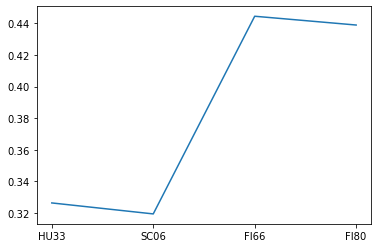

In [26]:
x, y = zip(*(versions_score.items()))

plt.plot(x, y)
plt.show()

In [27]:
chroma_type_score

{'stft': 0.34895708333333336,
 'cq': 0.4203120833333333,
 'cens': 0.37760374999999996}

Same as question 1, the CQT chroma method has the best performance. The difference is that the gap is now more significant.

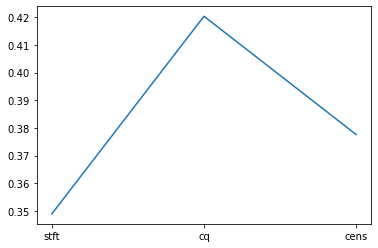

In [28]:
x, y = zip(*(chroma_type_score.items()))

plt.plot(x, y)
plt.show()

In [29]:
templates_score

{'binary_templates': 0.3833329166666666,
 'ks_templates': 0.3770825,
 'harmonic_templates': 0.38645749999999995}

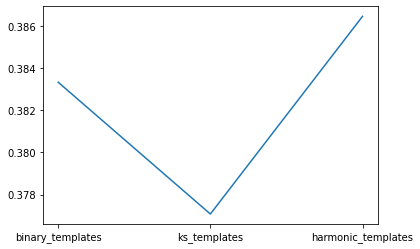

In [30]:
x, y = zip(*(templates_score.items()))

plt.plot(x, y)
plt.show()

All three templates has close performance for this dataset.

In [33]:
methods_score

{'raw': 0.37731444444444445, 'weighted': 0.38726749999999993}

# Q4

In [238]:
def predict_frame_key(chroma_frame, major_template, minor_template, tonic_pitch: int):
    """
    Tonic_pitch start with A
    
    """
    
    shifted_major_template = np.roll(major_template, -3 + tonic_pitch)
    shifted_minor_template = np.roll(minor_template, -3 + tonic_pitch)
    # -3 becuase input tempalte tonic is C
    
    
    major_pcc = stats.pearsonr(chroma_frame, shifted_major_template)[0]
    minor_pcc = stats.pearsonr(chroma_frame, shifted_minor_template)[0]
    
    if major_pcc > minor_pcc:
        return tonic_pitch # Major
    else:
        return tonic_pitch+12 # Minor

In [243]:
templates = {}

templates['binary'] = binary_templates
templates['ks'] = ks_templates
templates['harmonic'] = harmonic_templates

version2fileType = {"FI66": ".mp3", "FI80": ".mp3", "HU33": ".wav", "SC06": ".wav", "midi": ".mid"}

In [435]:
predict = {}
for v in versions:
    if v == 'midi':
        continue
    predict[v] = {}
    for n in range(1, 25):
        predict[v][n] = {}
        
        filename = "data/SWD/01_RawData/audio_wav/" + v + "/Schubert_D911-" + str(n).zfill(2) + "_" + v + version2fileType[v]
        y, sr = librosa.load(filename)
        chroma = {}

        # STFT chromagram
        chroma['stft'] = librosa.feature.chroma_stft(
            y=y, sr=sr, n_chroma=12, n_fft=2048, hop_length=int(sr*0.1))

        # CQT chromagram
        chroma['cq'] = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=int(sr*0.1))

        # Chroma Energy Normalized chromagram
        chroma['cens'] = librosa.feature.chroma_cens(y=y, sr=sr, hop_length=int(sr*0.1))
    
        chroma_temp = {}
        chroma_len = chroma['stft'].shape[1]


        chroma_temp['stft'] = np.copy(chroma['stft'])
        chroma_temp['cq'] = np.copy(chroma['cq'])
        chroma_temp['cens'] = np.copy(chroma['cens'])
        mean_pooling_size = 300
        for c in chroma_type:
            for i in range(chroma_len):
                for j in range(12):
                    if i < mean_pooling_size:
                        chroma_temp[c][j][i] = np.sum(chroma[c][j][0: mean_pooling_size])
                    elif i > chroma_len - mean_pooling_size:
                        chroma_temp[c][j][i] = np.sum(chroma[c][j][chroma_len - mean_pooling_size: chroma_len])
                    else:
                        chroma_temp[c][j][i] = np.sum(chroma[c][j][(i - int(mean_pooling_size/2)): (i + int(mean_pooling_size/2))])
                    chroma_temp[c][j][i] /= mean_pooling_size

            chroma_temp[c] = chroma_temp[c].T
        
        for c in chroma_type:
            predict[v][n][c] = {}
            for t in template_type:
                predict[v][n][c][t] = []

                filename = 'result/SWD/local_predict/' + v + '/' + str(n) + '/' + c + '/' + t + '.txt'
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:
                    for i in range(chroma_len):
                        tonic_pitch = (chroma_temp[c][i].argmax()+3)%12
                        key = predict_frame_key(chroma_temp[c][i], templates[t][0], templates[t][1], tonic_pitch)
                        f.write(str(key) + '\n')
                        predict[v][n][c][t].append(key)

C:\Users\pride829\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [304]:
def get_raw_local_acc(p, y):
    
    length = min(len(p), len(y))
    count = 0
    for i in range(length):
        if p[i] == y[i]:
            count += 1
    return round(count / length, 5)
    
def get_weighted_local_acc(p, y):
    """
    Refer to the weighted accuracy of Task 1 to see how weighting works.
    """
    length = min(len(p), len(y))
    score = 0
    for i in range(length):
        if p[i] == y[i]:
            score += 1
        elif (p[i]+7)%12 == y[i]:
            score += 0.5
        elif p[i] < 12:
            if p[i] + 9 == y[i]:
                score += 0.3
            elif p[i] + 12 == y[i]:
                score += 0.2
        elif p[i] >= 12:
            if (p[i] + 3)%12 == y[i]:
                score += 0.3
            elif p[i] - 12 == y[i]:
                score += 0.2
    return round(score / length, 5)

In [412]:
import pandas as pd

local_score = {}
for v in versions:
    if v == 'midi':
        continue
    
    local_score[v] = {}
    for n in range(1, 25):
        local_score[v][n] = {}
        
        df = pd.read_csv('data/SWD/02_Annotations/ann_audio_localkey-ann1/Schubert_D911-' + str(n).zfill(2) + '_' + v +'.csv', sep=';')

        y = []
        frame_i = 0
        for i in range(df.shape[0]):
            next_stop_time = float(df.loc[i]['end'])
            while(float(frame_i)/10 <= next_stop_time):
                y.append(key2num[df.loc[i]['key']])
                frame_i += 1
                
        for c in chroma_type:
            local_score[v][n][c] = {}
            for t in template_type:
                local_score[v][n][c][t] = {}
                local_score[v][n][c][t]['raw'] = get_raw_local_acc(predict[v][n][c][t], y)
                local_score[v][n][c][t]['weighted'] = get_weighted_local_acc(predict[v][n][c][t], y)

In [437]:
local_score

{'HU33': {1: {'stft': {'binary': {'raw': 0.01865, 'weighted': 0.03549},
    'ks': {'raw': 0.01865, 'weighted': 0.03549},
    'harmonic': {'raw': 0.01865, 'weighted': 0.03549}},
   'cq': {'binary': {'raw': 0.11711, 'weighted': 0.144},
    'ks': {'raw': 0.11711, 'weighted': 0.144},
    'harmonic': {'raw': 0.11711, 'weighted': 0.144}},
   'cens': {'binary': {'raw': 0.13477, 'weighted': 0.1859},
    'ks': {'raw': 0.13477, 'weighted': 0.1859},
    'harmonic': {'raw': 0.13477, 'weighted': 0.1859}}},
  2: {'stft': {'binary': {'raw': 0.10833, 'weighted': 0.10833},
    'ks': {'raw': 0.10833, 'weighted': 0.10833},
    'harmonic': {'raw': 0.10833, 'weighted': 0.10833}},
   'cq': {'binary': {'raw': 0.10417, 'weighted': 0.10542},
    'ks': {'raw': 0.10417, 'weighted': 0.10542},
    'harmonic': {'raw': 0.10417, 'weighted': 0.10542}},
   'cens': {'binary': {'raw': 0.10417, 'weighted': 0.10417},
    'ks': {'raw': 0.10417, 'weighted': 0.10417},
    'harmonic': {'raw': 0.10417, 'weighted': 0.10417}}},
 

## MIDI

In [403]:
midi_predict = {}
for n in range(1, 25):

    filename = "data/SWD/01_RawData/score_midi/Schubert_D911-" + str(n).zfill(2)+ ".mid"
    midi_data = pretty_midi.PrettyMIDI(filename)

    chroma_midi = midi_data.get_chroma(fs=10)
    
    chroma_len = chroma_midi.shape[1]
    
    chroma_midi_temp = chroma_midi.copy()
    
    mean_pooling_size = 300
    for i in range(chroma_len):
        for j in range(12):
            if i < mean_pooling_size:
                chroma_midi_temp[j][i] = np.sum(chroma_midi[j][0: mean_pooling_size])
            elif i > chroma_len - mean_pooling_size:
                chroma_midi_temp[j][i] = np.sum(chroma_midi[j][chroma_len - mean_pooling_size: chroma_len])
            else:
                chroma_midi_temp[j][i] = np.sum(chroma_midi[j][(i - int(mean_pooling_size/2)): (i + int(mean_pooling_size/2))])
            
    chroma_midi_temp /= mean_pooling_size
    chroma_midi_temp = chroma_midi_temp.T
    

    midi_predict[n] = {}
    for t in template_type:
        midi_predict[n][t] = []

        filename = 'result/SWD/local_predict/midi/' +str(n) + '/' + t + '.txt'
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, mode='w') as f:
            for i in range(chroma_len):
                tonic_pitch = (chroma_midi_temp[i].argmax()+3)%12
                key = predict_frame_key(chroma_midi_temp[i], templates[t][0], templates[t][1], tonic_pitch)
                f.write(str(key) + '\n')
                midi_predict[n][t].append(key)

In [414]:
midi_local_score = {}

for n in range(1, 25):
    midi_local_score[n] = {}

    df_measure = pd.read_csv('data/SWD/02_Annotations/ann_score_localkey-ann1/Schubert_D911-' + str(n).zfill(2) + '.csv', sep=';')
    df_time_per_measure = pd.read_csv('data/SWD/02_Annotations/time_per_measure_ann_score_localkey-ann1/Schubert_D911-' + str(n).zfill(2) + '.csv', sep=',')
    
    
    y = []
    frame_i = 0
    for i in range(df_measure.shape[0]):
        measure = df_measure.loc[i]['end']
        times0 = df_time_per_measure.loc[df_time_per_measure['Measure'].isin([int(measure)])].iloc[0]['Time']
        times1 = df_time_per_measure.loc[df_time_per_measure['Measure'].isin([int(measure)+1])].iloc[0]['Time']
        next_stop_time = times0 + (measure - int(measure)) * (times1 - times0)
        while(float(frame_i)/10 <= next_stop_time):
            y.append(key2num[df_measure.loc[i]['key']])
            frame_i += 1
    
    for t in template_type:
        midi_local_score[n][t] = {}
        midi_local_score[n][t]['raw'] = get_raw_local_acc(midi_predict[n][t], y)
        midi_local_score[n][t]['weighted'] = get_weighted_local_acc(midi_predict[n][t], y)
    

In [415]:
midi_local_score

{1: {'binary': {'raw': 0.43821, 'weighted': 0.44819},
  'ks': {'raw': 0.43116, 'weighted': 0.44255},
  'harmonic': {'raw': 0.44762, 'weighted': 0.45571}},
 2: {'binary': {'raw': 0.22162, 'weighted': 0.22162},
  'ks': {'raw': 0.20961, 'weighted': 0.21201},
  'harmonic': {'raw': 0.22162, 'weighted': 0.22162}},
 3: {'binary': {'raw': 0.0, 'weighted': 0.04452},
  'ks': {'raw': 0.0, 'weighted': 0.04452},
  'harmonic': {'raw': 0.0, 'weighted': 0.04452}},
 4: {'binary': {'raw': 0.14178, 'weighted': 0.14405},
  'ks': {'raw': 0.12113, 'weighted': 0.12753},
  'harmonic': {'raw': 0.14178, 'weighted': 0.14405}},
 5: {'binary': {'raw': 0.04088, 'weighted': 0.04088},
  'ks': {'raw': 0.04088, 'weighted': 0.04088},
  'harmonic': {'raw': 0.03295, 'weighted': 0.03453}},
 6: {'binary': {'raw': 0.0, 'weighted': 0.03289},
  'ks': {'raw': 0.03667, 'weighted': 0.06222},
  'harmonic': {'raw': 0.0, 'weighted': 0.03289}},
 7: {'binary': {'raw': 0.0, 'weighted': 0.0},
  'ks': {'raw': 0.0, 'weighted': 0.0},
  'ha

## Q4: analysis

In [417]:
methods = ["raw", "weighted"]

versions_score = {}
versions_count = 24*3*3*2
chroma_type_score = {}
chroma_type_count = 24*4*3*2
templates_score = {}
templates_count = 24*4*3*2
methods_score = {}
methods_count = 24*4*3*3

for v in versions:
    if v == 'midi':
        continue
    for n in range(1,25):
        for c in chroma_type:
            for t in templates:
                for m in methods:
                    
                    score = float(local_score[v][n][c][t][m])

                    if v not in versions_score:
                        versions_score[v] = score
                    else:
                        versions_score[v] += score

                    if c not in chroma_type_score:
                        chroma_type_score[c] = score
                    else:
                        chroma_type_score[c] += score

                    if t not in templates_score:
                        templates_score[t] = score
                    else:
                        templates_score[t] += score

                    if m not in methods_score:
                        methods_score[m] = score
                    else:
                        methods_score[m] += score

In [418]:
versions_score = {k: v/versions_count for k, v in versions_score.items()}
chroma_type_score = {k: v/chroma_type_count for k, v in chroma_type_score.items()}
templates_score = {k: v/templates_count for k, v in templates_score.items()}
methods_score = {k: v/methods_count for k, v in methods_score.items()}

In [419]:
versions_score

{'HU33': 0.23175530092592614,
 'SC06': 0.2460355787037035,
 'FI66': 0.3166175694444444,
 'FI80': 0.3441845370370367}

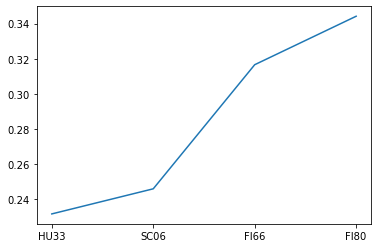

In [423]:
x, y = zip(*(versions_score.items()))

plt.plot(x, y)
plt.show()

整體來說，試著判斷local key的表現比判斷global key要來的差。四種version的準確率均下降了大約10%。而version之間的比較則和global key差不多。

In [420]:
chroma_type_score

{'stft': 0.25005288194444447,
 'cq': 0.30513930555555574,
 'cens': 0.2987525520833337}

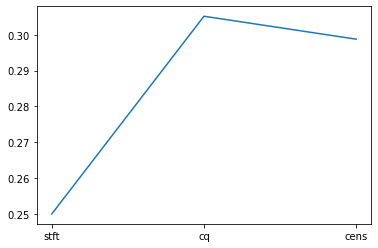

In [424]:
x, y = zip(*(chroma_type_score.items()))

plt.plot(x, y)
plt.show()

和global key相同，仍然是cqt判斷的準確率最高

In [421]:
templates_score

{'binary': 0.28045831597222265,
 'ks': 0.2873748784722221,
 'harmonic': 0.28611154513888915}

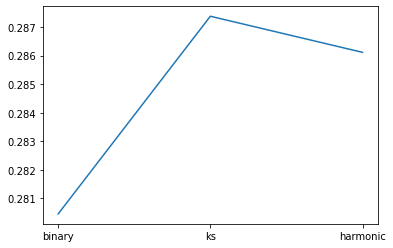

In [425]:
x, y = zip(*(templates_score.items()))

plt.plot(x, y)
plt.show()

和global key不同的是，在判斷local key方面三種templates的表現相差無幾。

In [422]:
methods_score

{'raw': 0.2707333217592592, 'weighted': 0.29856317129629634}

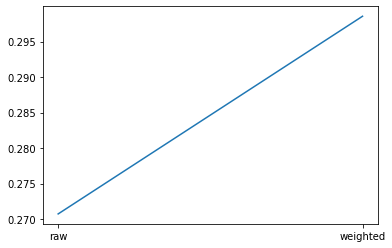

In [426]:
x, y = zip(*(methods_score.items()))

plt.plot(x, y)
plt.show()

In [428]:
templates_score = {}
templates_count = 24*2
methods_score = {}
methods_count = 24*3


for n in range(1,25):
    for t in templates:
        for m in methods:

            score = float(midi_local_score[n][t][m])

            if t not in templates_score:
                templates_score[t] = score
            else:
                templates_score[t] += score

            if m not in methods_score:
                methods_score[m] = score
            else:
                methods_score[m] += score

In [430]:
templates_score = {k: v/templates_count for k, v in templates_score.items()}
methods_score = {k: v/methods_count for k, v in methods_score.items()}

In [431]:
templates_score

{'binary': 0.3433283333333334,
 'ks': 0.32728374999999993,
 'harmonic': 0.33078770833333326}

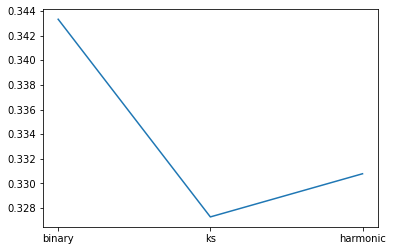

In [434]:
x, y = zip(*(templates_score.items()))

plt.plot(x, y)
plt.show()

和global key截然不同的是，midi檔案的chroma分析在local key prediction是可行的。整體的準確率大約在30%左右之間。

In [433]:
methods_score

{'raw': 0.32110763888888877, 'weighted': 0.3464922222222223}